# Example Two: Animals-10

**In this example, I will do the following:**

    1. Build my own model and eval
    2. Use pretrained model and best weights possible and compare
    3. Choose the best model and plot the loss curves and confusion matrix

In [99]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
import pandas as pd

from typing import List, Dict, Tuple, Final
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchmetrics import Accuracy, ConfusionMatrix
from torch.utils.data import DataLoader
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from torchinfo import summary

In [3]:
print(f'PyTorch Version: {torch.__version__}')
print(f'torchvision Version: {torchvision.__version__}')

PyTorch Version: 2.0.0.dev20230228
torchvision Version: 0.15.0.dev20230227


## 1. Data Preparation and Exploration

In [4]:
!export

CLICOLOR=1
CLICOLOR_FORCE=1
COMMAND_MODE=unix2003
FORCE_COLOR=1
GIT_PAGER=cat
HOME=/Users/nikolai
HOMEBREW_BOTTLE_DOMAIN=https://mirrors.ustc.edu.cn/homebrew-bottles
HOMEBREW_CELLAR=/opt/homebrew/Cellar
HOMEBREW_PREFIX=/opt/homebrew
HOMEBREW_REPOSITORY=/opt/homebrew
INFOPATH=/opt/homebrew/share/info:
JPY_PARENT_PID=14421
KMP_DUPLICATE_LIB_OK=True
KMP_INIT_AT_FORK=FALSE
LC_CTYPE=en_US.UTF-8
LESS=-R
LOGIN_SHELL=1
LOGNAME=nikolai
LSCOLORS=Gxfxcxdxbxegedabagacad
MANPATH=/opt/homebrew/share/man::
MPLBACKEND=module://matplotlib_inline.backend_inline
OLDPWD=/Users/nikolai/Documents/Repo/PyTorch/Animals
PAGER=cat
PATH=/Users/nikolai/PycharmProjects/pythonProject/venv/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin
PS1=$'(venv) %(?:%{\C-[%}➜ :%{\C-[%}➜ ) %{$fg[cyan]%}%c%{$reset_color%} $(git_prompt_info)'

PYTORCH_ENABLE_MPS_FALLBACK=1
SHELL=/bin/zsh
SHLVL=2
SSH_AUTH_SOCK=/

In [2]:
# setting up the training and testing directory
train_dir = 'raw-img/train'
test_dir = 'raw-img/test'

In [3]:
# set up train and test transforms, using TrivialAugmentWide to transform train data for more accuracy
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [4]:
# set up train and test data using ImageFolder
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform,
    target_transform=None
)

In [5]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 20882
     Root location: raw-img/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 5297
     Root location: raw-img/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [6]:
train_data.classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [7]:
train_data.classes == test_data.classes

True

In [8]:
class_names = train_data.classes

In [9]:
image, label = next(iter(train_data))

In [10]:
image.shape, class_names[label]

(torch.Size([3, 224, 224]), 'butterfly')

In [11]:
torch.backends.mps.is_available()

True

In [12]:
# make a function to preview an image
def preview_image(data: Tuple):
    plt.imshow(data[0].permute(1, 2, 0))
#     plt.axis(False)
    plt.xlabel(class_names[data[1]])
    plt.ylabel(data[0].shape)
    plt.show()

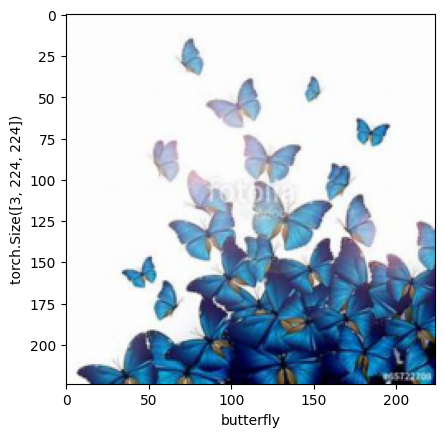

In [13]:
preview_image(train_data[0])

In [29]:
# set up dataloader
BATCH_SIZE : Final = 64
    
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False,
    pin_memory=True
)

In [30]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x328105090>,
 <torch.utils.data.dataloader.DataLoader at 0x3281045b0>)

## 2. Building Baseline Model

In [31]:
class AnimalsBaselineModel(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 3 * 3,
                out_features=output_shape
            )
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))
    
    def __name__(self):
        return 'AnimalsBaselineModel'

In [32]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [33]:
model_0 = AnimalsBaselineModel(input_shape=3, output_shape=10, hidden_units=50).to(device)

In [34]:
model_0

AnimalsBaselineModel(
  (block1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=450, out_features=10, bias=True)
  )
)

In [35]:
dummy = torch.randn(size=(3, 224, 224)).to(device)

In [36]:
# use a dummy data to detect any fault in the model
with torch.inference_mode():
    dummy_pred = model_0(dummy.unsqueeze(0))
torch.softmax(dummy_pred, dim=1).argmax(dim=1), dummy_pred.argmax(dim=1), class_names[dummy_pred.argmax(dim=1)]

(tensor([6], device='mps:0'), tensor([6], device='mps:0'), 'horse')

## 2. Setup Train and Test Loop

In [37]:
def train_step(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    optim: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader
):
    train_loss, train_acc = 0, 0
    model.train()
    print('Starting training cycle:\n------------')
    
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_function(y_pred.argmax(dim=1), y).item()
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc*100

In [38]:
def test_step(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    dataloader: torch.utils.data.DataLoader
):
    test_loss, test_acc = 0, 0
    model.eval()
    print('Starting testing cycle:\n--------------')
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_function(y_pred, y).item()
            test_acc += accuracy_function(y_pred.argmax(dim=1), y).item()
            
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        
    return test_loss, test_acc*100

In [39]:
def train_model(
    model: nn.Module,
    loss_function: nn.Module,
    optim: torch.optim.Optimizer,
    accuracy_function,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5
) -> Dict:
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    for _ in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                  loss_function=loss_function,
                  optim=optim,
                  accuracy_function=accuracy_function,
                  dataloader=train_loader)
        
        test_loss, test_acc = test_step(model=model,
                 loss_function=loss_function,
                 accuracy_function=accuracy_function,
                 dataloader=test_loader)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        
    return results

## 3. Train the Baseline Model 

In [40]:
# set up optimizer, loss function and accuracy function
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [41]:
model_0_result = train_model(model=model_0,
                            loss_function=loss_fn,
                            accuracy_function=acc_fn,
                            optim=optimizer,
                            train_loader=train_dataloader,
                            test_loader=test_dataloader,
                            epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 2.1238 | Train Acc: 22.52% | Test Loss: 1.9413 | Test Acc: 31.73%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.6860 | Train Acc: 42.14% | Test Loss: 1.6047 | Test Acc: 45.67%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.4727 | Train Acc: 50.33% | Test Loss: 1.5109 | Test Acc: 49.08%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.3493 | Train Acc: 54.38% | Test Loss: 1.4066 | Test Acc: 52.44%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.2694 | Train Acc: 57.11% | Test Loss: 1.3314 | Test Acc: 54.84%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.1987 | Train Acc: 59.80% | Test Loss: 1.3457 | Test Acc: 55.45%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.1439 | Train Acc: 61.29% | Test Loss: 1.2746 | Test Acc: 56.85%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0939 | Train Acc: 62.97% | Test Loss: 1.2443 | Test Acc: 58.56%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0509 | Train Acc: 64.71% | Test Loss: 1.2737 | Test Acc: 57.69%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0178 | Train Acc: 65.51% | Test Loss: 1.2001 | Test Acc: 59.81%


**Looks like the model is not really performing only ok, let's plot the loss curves.**

In [42]:
def plot_curves_single(result: Dict[str, List[float]]):
    
    trainloss = result['train_loss']
    trainacc = result['train_acc']    
    testloss = result['test_loss']
    testacc = result['test_acc']
    
    epochs = range(len(result['train_loss']))
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainloss, label='Train Loss')
    plt.plot(epochs, testloss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.title('Loss Curve')
    plt.ylim(0, 2.5)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainacc, label='Train Acc')
    plt.plot(epochs, testacc, label='Test Acc')
    plt.xlabel('Epoch')
    plt.title('Acc Curve')
    plt.ylim((0, 100))
    plt.legend()
    
    plt.show()

In [43]:
def dict_to_df(raw_dict: List):
    converted = []
    for index, dic in enumerate(raw_dict):
        convert = pd.DataFrame(dic)
        convert['model_name'] = f'model_{index}'
        converted.append(convert)
    df_combined = pd.concat(converted, ignore_index=True, axis=0)
    return df_combined

In [82]:
def plot_curves(*result):
    results = list(result)
    if len(results) == 0:
        raise ValueError(
            'Expected at least one result to be able to plot!'
        )
    if len(results) == 1:
        plot_curves_single(results[0])
        return
    df = dict_to_df(results)
    col_names = list(df.iloc[:, :4].columns)
    length = []
    for l in list(df['model_name'].unique()):
        length.append(len(df.loc[df['model_name']==l]))
    epochs = range(max(length))
    model_names = list(df['model_name'].unique())
#     num_models = len(df['model_name'].unique())
    plt.figure(figsize=(10, 10))
    for i, col in enumerate(col_names):
        plt.subplot(2, 2, i+1)
        for j, model in enumerate(model_names):
            plt.plot(epochs, np.array(df.loc[df.model_name==model, col]), label=model)
        plt.xlabel('Epoch')
        plt.title(f'{col.split("_")[0]} {col.split("_")[1]}', fontsize=10)
        if col == 'train_loss' or col == 'test_loss':
            plt.ylim((0, 2.5))
        elif col == 'train_acc' or col == 'test_acc':
            plt.ylim((0, 100))
        plt.legend()
    plt.tight_layout(pad=3.0)
    plt.show()

In [45]:
model_0_result

{'train_loss': [2.1237833623856943,
  1.6859795624327587,
  1.472705351467891,
  1.3492590280118704,
  1.269384768031059,
  1.1986714235139548,
  1.1438559747617179,
  1.093861613798579,
  1.0509034632178258,
  1.0178111643966186],
 'train_acc': [22.516883285402887,
  42.142371737628906,
  50.327578159647246,
  54.37691131498471,
  57.1132772741697,
  59.795489296636084,
  61.29268603769646,
  62.96721033364625,
  64.70969249166845,
  65.50925926330986],
 'test_loss': [1.9413261456661914,
  1.604741495057761,
  1.510881727000317,
  1.4066123969583626,
  1.331428039145757,
  1.3456929896969394,
  1.2745833246104687,
  1.2442502946738738,
  1.2737380370318172,
  1.2000873246824886],
 'test_acc': [31.726395376924295,
  45.66710720579309,
  49.07871280089918,
  52.44383144091411,
  54.836181452475394,
  55.45280611658671,
  56.85048868139106,
  58.56205433248037,
  57.685717329921495,
  59.810287047581504]}

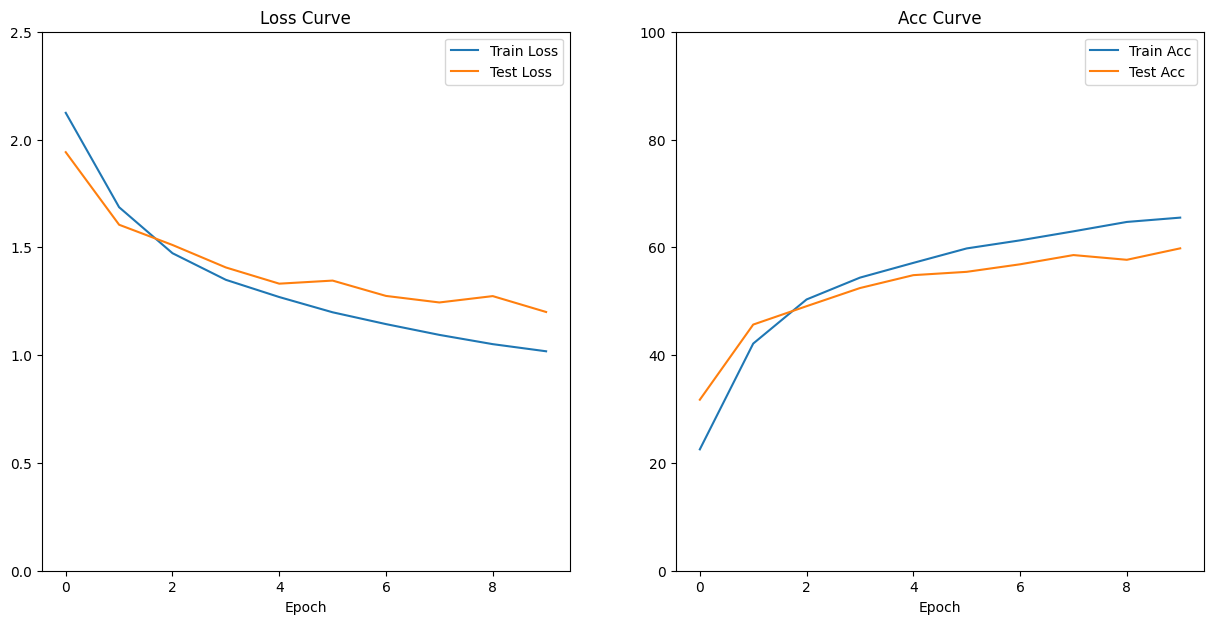

In [46]:
plot_curves(model_0_result)

**Looks like the model is not performing ideally due to severe underfitting. Let's see if we can tune the model for it to do better.**

In [47]:
# making a evaluate function
def eval_model(
    model: nn.Module,
    loss_function: nn.Module,
    accuracy_function,
    dataloader: torch.utils.data.DataLoader
):
    loss, acc = 0, 0
    model.eval()
    print(f'Evaluating...\n------------')
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
            loss += loss_function(y_logit, y).item()
            acc += accuracy_function(y_pred, y).item()
        
        loss /= len(dataloader)
        acc /= len(dataloader)
    return {
        'Model Name': model.__class__.__name__,
        'Loss': loss,
        'Accuracy': acc*100
    }

In [48]:
model_0_eval = eval_model(model=model_0, loss_function=loss_fn, accuracy_function=acc_fn, dataloader=test_dataloader)
model_0_eval

Evaluating...
------------


  0%|          | 0/83 [00:00<?, ?it/s]

{'Model Name': 'AnimalsBaselineModel',
 'Loss': 1.2000873246824886,
 'Accuracy': 59.810287047581504}

In [49]:
# saving the baseline model's state dict
torch.save(model_0.state_dict(), 'BaseLineModel.pt')

## 4. Improving Baseline Model

In [50]:
class AnimalsModelV1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=2,
                padding=0
            ),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3*3,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.block2(self.block1(x)))

In [60]:
model_1 = AnimalsModelV1(input_shape=3, output_shape=10, hidden_units=100).to(device)

In [61]:
model_1

AnimalsModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=900, out_features=10, bias=True)
  )
)

In [62]:
dummy.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [63]:
with torch.inference_mode():
    temp_pred = model_1(dummy.unsqueeze(0))

In [64]:
class_names[test_data[0][1]], class_names[temp_pred.argmax(dim=1)]

('butterfly', 'sheep')

In [65]:
optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                              lr=0.001)

In [66]:
model_1_result = train_model(model=model_1,
                            loss_function=loss_fn,
                            accuracy_function=acc_fn,
                            optim=optimizer_1,
                            train_loader=train_dataloader,
                            test_loader=test_dataloader,
                            epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.7209 | Train Acc: 40.39% | Test Loss: 1.4887 | Test Acc: 49.15%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.2673 | Train Acc: 57.23% | Test Loss: 1.2641 | Test Acc: 57.41%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0307 | Train Acc: 65.33% | Test Loss: 1.1428 | Test Acc: 61.53%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.8544 | Train Acc: 71.47% | Test Loss: 1.1326 | Test Acc: 63.39%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.7020 | Train Acc: 76.00% | Test Loss: 1.1845 | Test Acc: 61.92%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.5548 | Train Acc: 81.41% | Test Loss: 1.2755 | Test Acc: 63.66%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.4333 | Train Acc: 85.09% | Test Loss: 1.4658 | Test Acc: 63.19%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.3091 | Train Acc: 89.23% | Test Loss: 1.5469 | Test Acc: 63.30%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.2377 | Train Acc: 91.92% | Test Loss: 1.7742 | Test Acc: 62.05%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.2078 | Train Acc: 92.66% | Test Loss: 2.0140 | Test Acc: 62.66%


In [67]:
model_1_result

{'train_loss': [1.720881366948469,
  1.267258612387771,
  1.0307154999960453,
  0.8543529649028719,
  0.7019556325145453,
  0.5548425475391773,
  0.433339511764888,
  0.30910925466897654,
  0.23766932463336063,
  0.20779416490266447],
 'train_acc': [40.38927115796174,
  57.232203541910245,
  65.3255606463196,
  71.46937648455301,
  75.99972391711827,
  81.40927624264988,
  85.08643391300049,
  89.22602361130787,
  91.92416327079866,
  92.66267415215846],
 'test_loss': [1.4886515815574002,
  1.264148815568671,
  1.1428364289094166,
  1.1325614398502442,
  1.1844684194369488,
  1.2755430879363094,
  1.4657860046409699,
  1.546932635178049,
  1.7741842959300582,
  2.0139600383230003],
 'test_acc': [49.152477247169216,
  57.4064113648541,
  61.52761557016028,
  63.38555751794792,
  61.922946895461486,
  63.6637109589864,
  63.19000491176743,
  63.30295671899635,
  62.054724003895224,
  62.65867040099869]}

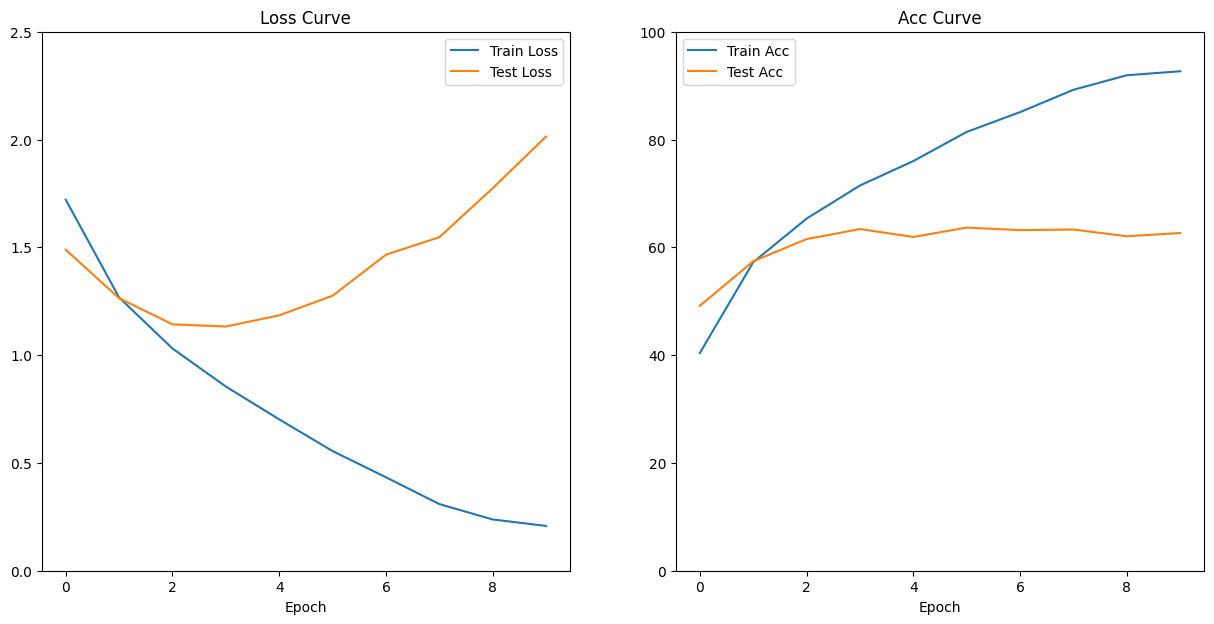

In [68]:
plot_curves(model_1_result)

In [69]:
model_1_eval = eval_model(model=model_1,
                         loss_function=loss_fn,
                         accuracy_function=acc_fn,
                         dataloader=test_dataloader)
model_1_eval

Evaluating...
------------


  0%|          | 0/83 [00:00<?, ?it/s]

{'Model Name': 'AnimalsModelV1',
 'Loss': 2.0139600383230003,
 'Accuracy': 62.65867040099869}

**Looks like the model is now better and can be improved even further if trained longer.**

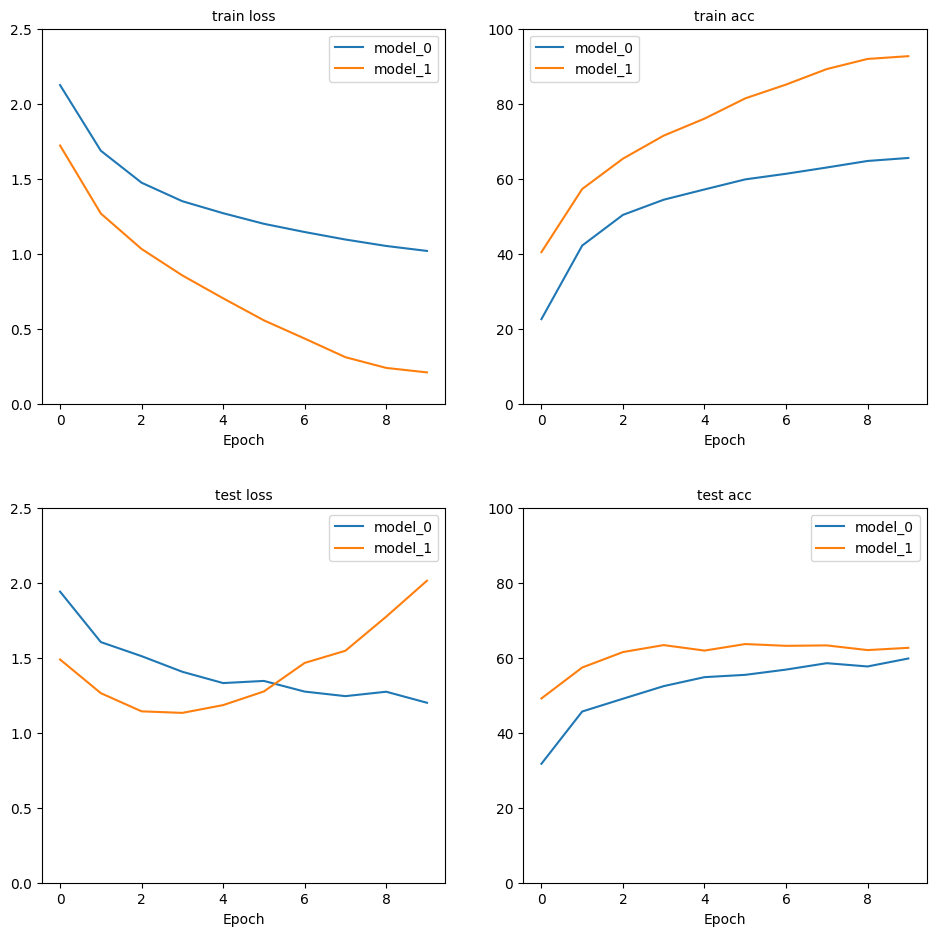

In [83]:
# comparison of the baseline and model_1
plot_curves(model_0_result, model_1_result)

**Looks like the model is overfitting a bit since the test loss is increasing while the train loss decreases. Let's do some experiments on this and see if it works.**

### 4.1 Experimenting on current model
* Add image augmentation to the dataloader
* Tweak the learning rate
* Add more layers
* Train for longer

In [71]:
# add augmentation to the transform
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [72]:
train_data_1 = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial,
    target_transform=None
)
    
train_dataloader_1 = DataLoader(
    dataset=train_data_1,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True
)

Now let's re-train model_1 and name it model_2

In [73]:
model_2 = AnimalsModelV1(input_shape=3, output_shape=len(class_names), hidden_units=100).to(device)
model_2

AnimalsModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=900, out_features=10, bias=True)
  )
)

In [74]:
optimizer_2 = torch.optim.Adam(params=model_2.parameters(),
                              lr=0.001)

In [75]:
model_2_result = train_model(
    model=model_2,
    loss_function=loss_fn,
    accuracy_function=acc_fn,
    train_loader=train_dataloader_1,
    test_loader=test_dataloader,
    optim=optimizer_2,
    epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.9269 | Train Acc: 33.09% | Test Loss: 1.6111 | Test Acc: 45.33%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.5750 | Train Acc: 46.55% | Test Loss: 1.4165 | Test Acc: 52.60%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.3892 | Train Acc: 53.18% | Test Loss: 1.1977 | Test Acc: 59.28%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.2827 | Train Acc: 56.85% | Test Loss: 1.1435 | Test Acc: 60.88%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.1836 | Train Acc: 60.32% | Test Loss: 1.0304 | Test Acc: 65.65%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.1175 | Train Acc: 62.57% | Test Loss: 1.0736 | Test Acc: 64.47%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0739 | Train Acc: 64.15% | Test Loss: 1.0040 | Test Acc: 66.56%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0246 | Train Acc: 65.72% | Test Loss: 1.0139 | Test Acc: 66.27%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.9748 | Train Acc: 67.35% | Test Loss: 1.0343 | Test Acc: 66.01%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.9501 | Train Acc: 68.64% | Test Loss: 0.9482 | Test Acc: 69.42%


In [76]:
model_2_eval = eval_model(model=model_2,
                         dataloader=test_dataloader,
                         loss_function=loss_fn,
                         accuracy_function=acc_fn)
model_2_eval

Evaluating...
------------


  0%|          | 0/83 [00:00<?, ?it/s]

{'Model Name': 'AnimalsModelV1',
 'Loss': 0.9481565121067576,
 'Accuracy': 69.42117961056262}

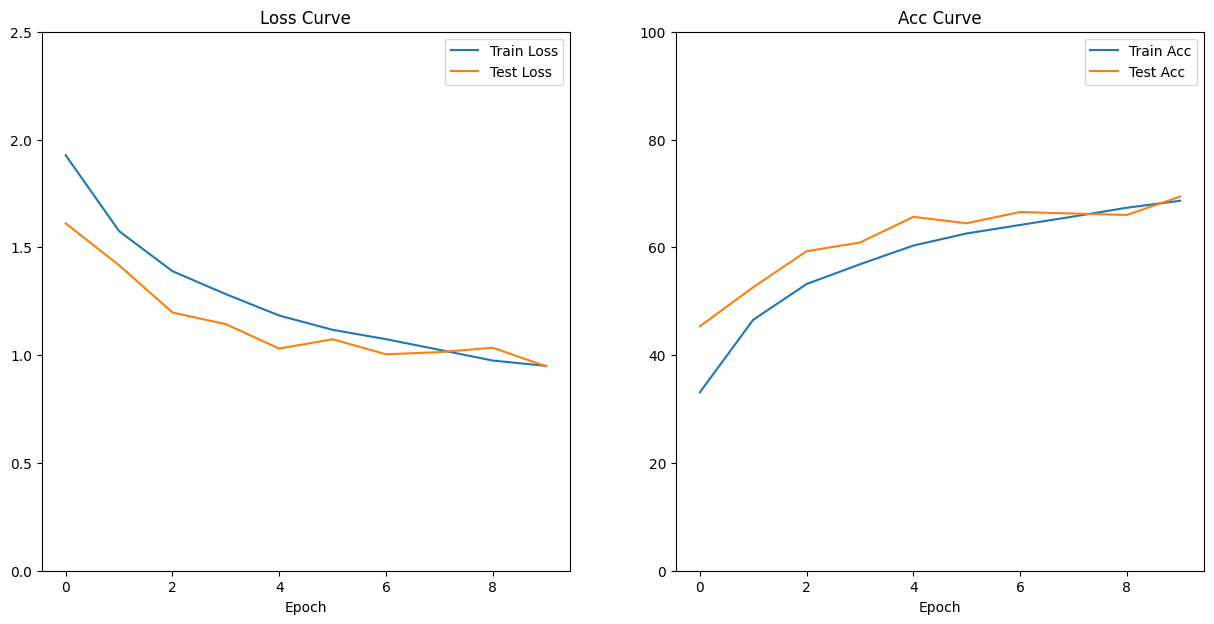

In [77]:
plot_curves(model_2_result)

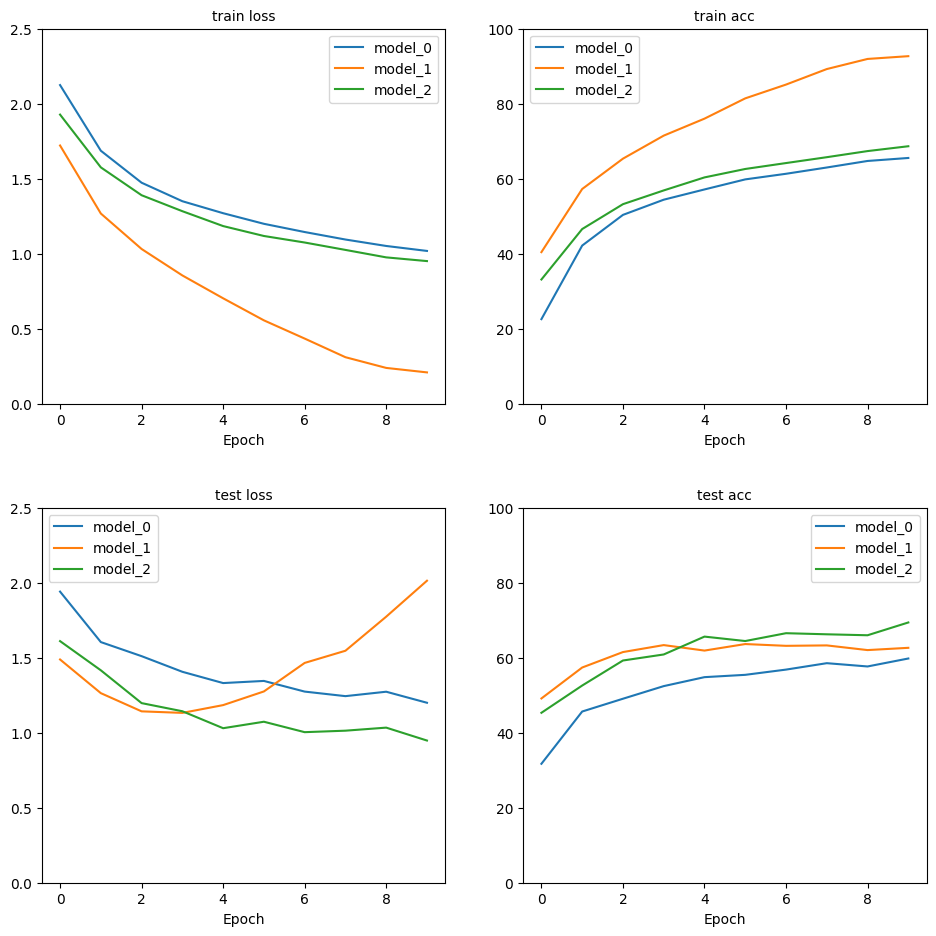

In [84]:
plot_curves(model_0_result, model_1_result, model_2_result)

In [85]:
# add more layers and lower the learning rate further
model_3 = AnimalsModelV1(input_shape=3, output_shape=len(class_names), hidden_units=200).to(device)
optimizer_3 = torch.optim.Adam(params=model_3.parameters(),
                              lr=0.001)

In [86]:
model_3

AnimalsModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 200, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(200, 200, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(200, 200, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(200, 200, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1800, out_features=10, bias=True)
  )
)

**Note: Depends on your hardware, this may take a while to finish.**

In [87]:
model_3_result = train_model(
    model=model_3,
    train_loader=train_dataloader_1,
    test_loader=test_dataloader,
    loss_function=loss_fn,
    accuracy_function=acc_fn,
    optim=optimizer_3,
    epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.9673 | Train Acc: 31.58% | Test Loss: 1.5655 | Test Acc: 46.65%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.5889 | Train Acc: 46.87% | Test Loss: 1.3097 | Test Acc: 54.85%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.3993 | Train Acc: 53.29% | Test Loss: 1.1473 | Test Acc: 61.00%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.2691 | Train Acc: 57.86% | Test Loss: 1.1129 | Test Acc: 63.22%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.2115 | Train Acc: 59.89% | Test Loss: 1.1103 | Test Acc: 62.48%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.1414 | Train Acc: 62.96% | Test Loss: 1.1163 | Test Acc: 64.19%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0805 | Train Acc: 64.37% | Test Loss: 1.1085 | Test Acc: 63.44%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 1.0496 | Train Acc: 66.04% | Test Loss: 1.1551 | Test Acc: 64.23%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.9959 | Train Acc: 67.91% | Test Loss: 1.0504 | Test Acc: 65.78%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.9558 | Train Acc: 68.72% | Test Loss: 1.1057 | Test Acc: 66.18%


In [88]:
model_3_eval = eval_model(model=model_3,
                         dataloader=test_dataloader,
                         accuracy_function=acc_fn,
                         loss_function=loss_fn)
model_3_eval

Evaluating...
------------


  0%|          | 0/83 [00:00<?, ?it/s]

{'Model Name': 'AnimalsModelV1',
 'Loss': 1.1057133864925568,
 'Accuracy': 66.18015428623522}

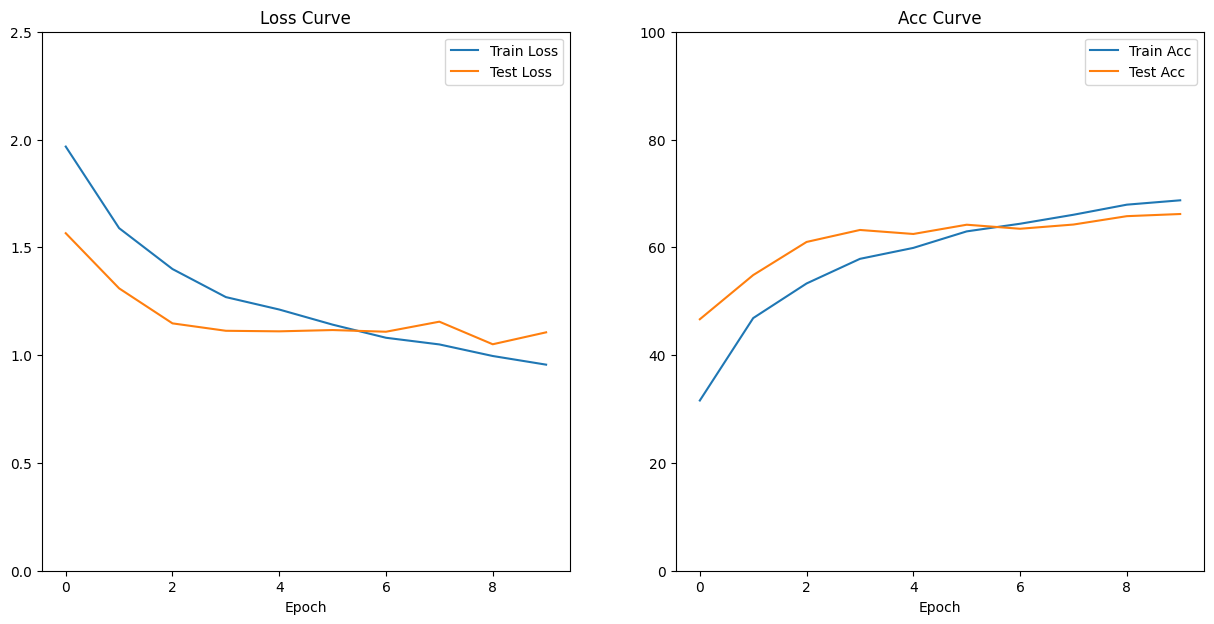

In [89]:
plot_curves(model_3_result)

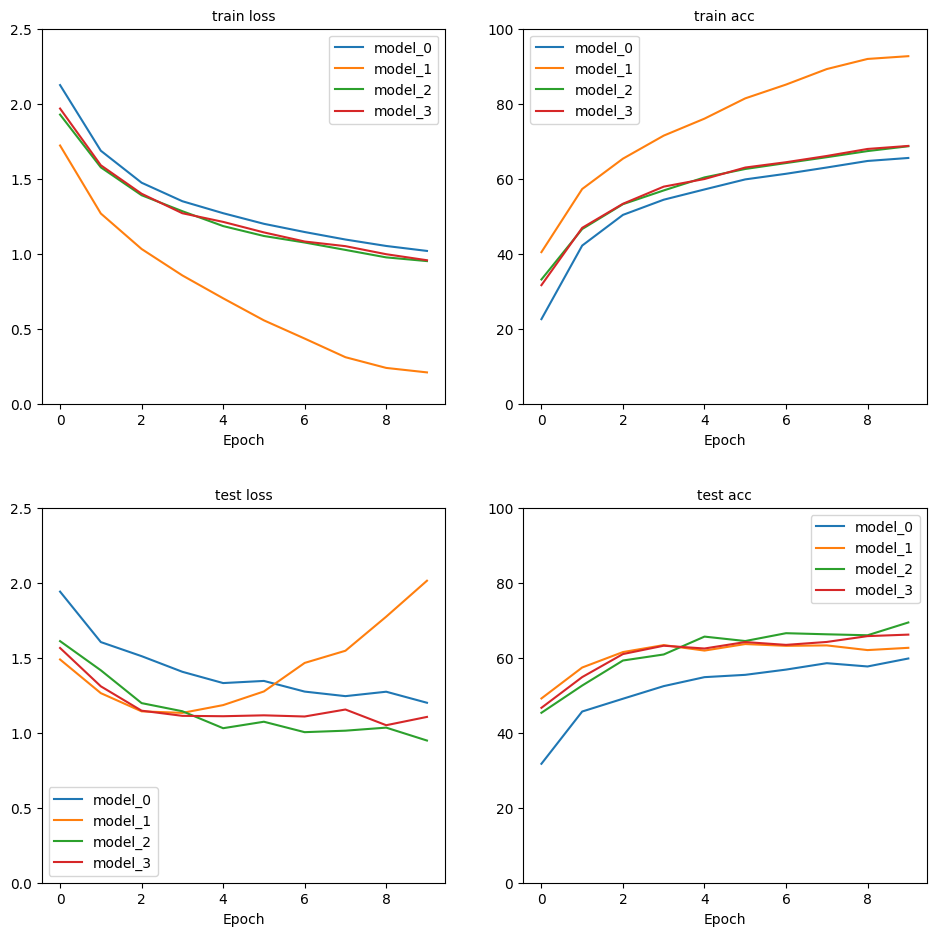

In [90]:
plot_curves(model_0_result, model_1_result, model_2_result, model_3_result)

**Looks like the model is now performing better than before with less overfitting and underfitting, maybe there is something else we can try out too.**

* Note that with tweaking the learning rate, the loss doesn't seem to go down much, so let's try to re-build a model with more methods.

**Let's save the model state dicts so far first.**

In [91]:
torch.save(model_1.state_dict(), 'Model_1.pt')
torch.save(model_2.state_dict(), 'Model_2.pt')
torch.save(model_3.state_dict(), 'Model_3.pt')

## 5. Tranfer Learning

In [132]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

In [133]:
weights = ResNet18_Weights.DEFAULT
weights

ResNet18_Weights.IMAGENET1K_V1

In [136]:
model_4 = models.resnet18(weights=weights).to(device)

In [138]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [139]:
train_data_transfer = datasets.ImageFolder(
    root=train_dir,
    transform=auto_transform,
    target_transform=None
)

test_data_transfer = datasets.ImageFolder(
    root=test_dir,
    transform=auto_transform,
    target_transform=None
)

train_dataloader_transfer = DataLoader(
    dataset=train_data_transfer,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True
)

test_dataloader_transfer = DataLoader(
    dataset=test_data_transfer,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False,
    pin_memory=True
)

In [140]:
model_4

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [141]:
for param in model_4.parameters():
    param.requires_grad = False

In [142]:
model_4.fc = nn.Linear(in_features=512, out_features=len(class_names), bias=True).to(device)

In [148]:
dummy = torch.randn(size=(32, 3, 224, 224)).to(device)

In [149]:
with torch.inference_mode():
    y_pred = model_4(dummy)

In [151]:
optimizer_resnet18 = torch.optim.Adam(params=model_4.parameters(),
                                     lr=0.001)

In [152]:
model_4_result = train_model(
    model=model_4,
    loss_function=loss_fn,
    accuracy_function=acc_fn,
    optim=optimizer_resnet18,
    train_loader=train_dataloader_transfer,
    test_loader=test_dataloader_transfer,
    epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.4045 | Train Acc: 89.73% | Test Loss: 0.1553 | Test Acc: 95.85%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1729 | Train Acc: 95.12% | Test Loss: 0.1317 | Test Acc: 96.15%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1482 | Train Acc: 95.70% | Test Loss: 0.1183 | Test Acc: 96.47%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1370 | Train Acc: 95.78% | Test Loss: 0.1263 | Test Acc: 96.14%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1292 | Train Acc: 96.22% | Test Loss: 0.1200 | Test Acc: 96.19%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1225 | Train Acc: 96.39% | Test Loss: 0.1121 | Test Acc: 96.47%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1197 | Train Acc: 96.13% | Test Loss: 0.1116 | Test Acc: 96.38%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1146 | Train Acc: 96.44% | Test Loss: 0.1227 | Test Acc: 96.08%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1098 | Train Acc: 96.60% | Test Loss: 0.1223 | Test Acc: 96.34%
Starting training cycle:
------------


  0%|          | 0/327 [00:00<?, ?it/s]

Starting testing cycle:
--------------


  0%|          | 0/83 [00:00<?, ?it/s]

Train Loss: 0.1079 | Train Acc: 96.67% | Test Loss: 0.1163 | Test Acc: 96.40%


In [153]:
model_4_eval = eval_model(model=model_4,
                         loss_function=loss_fn,
                         accuracy_function=acc_fn,
                         dataloader=test_dataloader_transfer)
model_4_eval

Evaluating...
------------


  0%|          | 0/83 [00:00<?, ?it/s]

{'Model Name': 'ResNet',
 'Loss': 0.1162935814291452,
 'Accuracy': 96.39860463429646}

In [154]:
y_preds = []
model_4.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader_transfer):
        X, y = X.to(device), y.to(device)
        y_logit = model_4(X)
        y_pred = torch.softmax(y_logit.squeeze(0), dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

  0%|          | 0/83 [00:00<?, ?it/s]

tensor([0, 0, 0,  ..., 9, 9, 9])

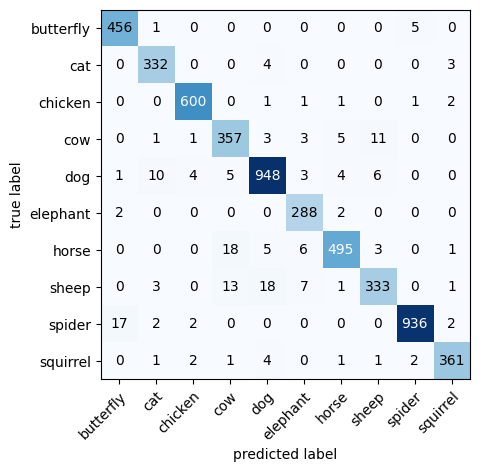

In [155]:
cm = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
cm_tensor = cm(preds=y_preds_tensor, target=torch.tensor(test_data_transfer.targets))
plot_confusion_matrix(conf_mat=cm_tensor.numpy(), class_names=class_names)
plt.show()

In [163]:
models_eval = [model_0_eval, model_1_eval, model_2_eval, model_3_eval, model_4_eval]

In [176]:
dfs = []
for model in models_eval:
    df = pd.DataFrame(model, index=[0])
    dfs.append(df)
df_models_eval = pd.concat(dfs, ignore_index=True, axis=0)
df_models_eval

,Model Name,Loss,Accuracy
0,AnimalsBaselineModel,1.200087,59.810287
1,AnimalsModelV1,2.013960,62.658670
2,AnimalsModelV1,0.948157,69.421180
3,AnimalsModelV1,1.105713,66.180154
4,ResNet,0.116294,96.398605


In [184]:
df_models_eval.iloc[0, 0] = 'Baseline'
df_models_eval.iloc[1, 0] = 'Model_1'
df_models_eval.iloc[2, 0] = 'Model_2'
df_models_eval.iloc[3, 0] = 'Model_3'

In [185]:
df_models_eval

,Model Name,Loss,Accuracy
0,Baseline,1.200087,59.810287
1,Model_1,2.013960,62.658670
2,Model_2,0.948157,69.421180
3,Model_3,1.105713,66.180154
4,ResNet,0.116294,96.398605


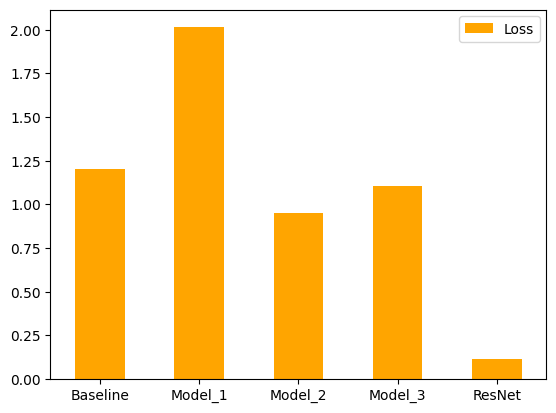

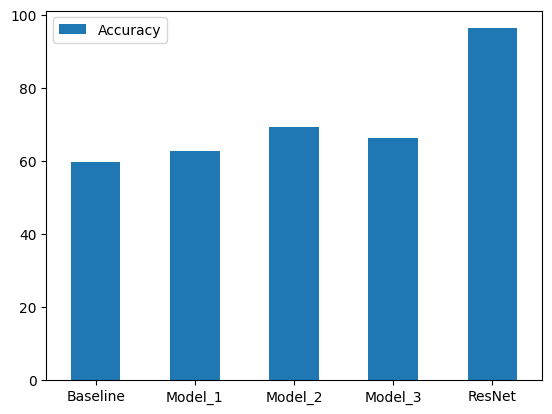

In [207]:
df_models_eval[['Model Name', 'Loss']].plot(kind='bar', color='orange')
plt.xticks(ticks=[0, 1, 2, 3, 4] ,labels=list(df_models_eval['Model Name']), rotation=0)
df_models_eval[['Model Name', 'Accuracy']].plot(kind='bar')
plt.xticks(ticks=[0, 1, 2, 3, 4] ,labels=list(df_models_eval['Model Name']), rotation=0)
plt.show()

In [208]:
torch.save(model_4.state_dict(), 'resnet18.pt')